# Lecture 8: Accelerating SGD with Momentum

## CS4787 — Principles of Large-Scale Machine Learning Systems

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\norm}[1]{\left\|#1\right\|}$
$\newcommand{\Exv}[1]{\mathbf{E}\left[#1\right]}$
$\newcommand{\Prob}[1]{\mathbf{P}\left(#1\right)}$
$\newcommand{\Var}[1]{\operatorname{Var}\left(#1\right)}$
$\newcommand{\Abs}[1]{\left|#1\right|}$

In [15]:
import numpy
import scipy
import matplotlib
from matplotlib import pyplot
import time

matplotlib.rcParams.update({'font.size': 12})

## Announcements

**Prelim Exam This Thursday**: Take-home, open-book, open-computer exam covering everything we've done up to that point (but with a focus on things that have appeared in problem sets and programming assignments). 24 hours, starting from the posted exam time, which is 8:30PM. (There will be a grace period after 8:30PM to submit, in case of technical errors, but please do not push it!) Submit your solutions on gradescope.

Again, let me know ASAP if you have any special circumstances that need to be taken into account.

I have **posted solutions to the second problem set** so you can use them as a resource to study for the prelim (and during the prelim). You can also look at these solutions to check your answers on the problem set you submitted, but please do not copy off of the solutions if you are submitting the pset late!

## Recall

When we analyzed gradient descent and SGD for strongly convex objectives, the convergence rate depended on the **condition number** $\kappa = L / \mu$.

For example, the noise ball size for SGD with a constant step size was determined by

$$\Exv{ f(w_T) - f^* }
  \le
  \left(1 - \alpha \mu \right)^T
  \cdot
  (f(w_0) - f^*)
  +
  \frac{\alpha \sigma^2 \kappa}{2}$$
  
and for gradient descent with constant step size, the convergence rate was

$$
  f(w_T) - f^*
  \le
  \exp\left(-\frac{T}{\kappa} \right) \cdot \left( f(w_0) - f^* \right).$$
  
**Takeaway: when the condition number is high, convergence can become slow. Motivates the question: How can we speed up gradient descent when the condition is high?**

* Spoiler: handling a large condition number is what **momentum** is designed to do, and momentum is probably the most common acceleration technique used with GD and SGD in machine learning...so I had to teach you about conditioning to give you the intuition to understand momentum.

### Simple quadratic

To build our intuition about the condition number, let's look at the simplest possible setting with a non-1 condition number: a 2D quadratic.

$$f(w) = f(w_1, w_2) = \frac{L}{2} w_1^2 + \frac{\mu}{2} w_2^2 = \frac{1}{2} \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}^T \begin{bmatrix} L & 0 \\ 0 & \mu \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}.$$

The optimum value occurs at $w^* = 0$ (where $f(w^*) = 0$), and the second derivative matrix is the constant

$$\nabla^2 f(w) = \begin{bmatrix} L & 0 \\ 0 & \mu \end{bmatrix},$$

Let's think about what gradient descent (with constant learning rate) is going to do on this problem.
The update rule will be"
\begin{align*}
  (w_{t+1})_1 &= (w_{t})_1 - \alpha L (w_t)_1 \\
  (w_{t+1})_2 &= (w_{t})_2 - \alpha \mu (w_t)_2.
\end{align*}
This means that
\begin{align*}
  \left( (w_T)_1 \right)^2 &= (1 - \alpha L)^{2T} \left( (w_0)_1 \right)^2 \\
  \left( (w_T)_2 \right)^2 &= (1 - \alpha \mu)^{2T} \left( (w_0)_2 \right)^2
\end{align*}

and so

$$f(w_T) = \frac{L}{2} (1 - \alpha L)^{2T} \left( (w_0)_1 \right)^2 + \frac{\mu}{2} (1 - \alpha \mu)^{2T} \left( (w_0)_2 \right)^2.$$

<div style="font-size:150%;color:forestgreen;font-weight:bold;text-align:center">What will dominate this loss asymptotically as $T$ increases?</div>

<div style="font-size:150%;color:blue;font-weight:bold;text-align:left">Answer: It's dominated by whichever term grows more slowly.</div>

$$f(w_T) = \mathcal{O}\left( \max(\Abs{1 - \alpha L}, \Abs{1 - \alpha \mu})^{2T}  \right).$$

So we have this expression for our quadratic...
$$f(w_T) = \mathcal{O}\left( \max(\Abs{1 - \alpha L}, \Abs{1 - \alpha \mu})^{2T}  \right).$$
Let's look at this inner max term as a function of $\alpha$.

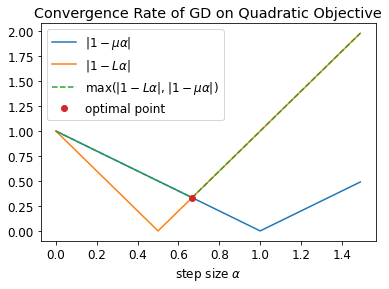

In [16]:
mu = 1.0
L = 2.0
alpha = numpy.arange(0,1.5,0.01)
alpha_opt = 2 / (L + mu);
pyplot.plot(alpha, numpy.abs(1 - mu * alpha), label = "$|1 - \\mu \\alpha|$");
pyplot.plot(alpha, numpy.abs(1 - L * alpha), label = "$|1 - L \\alpha|$");
pyplot.plot(alpha, numpy.maximum(numpy.abs(1 - L * alpha),numpy.abs(1 - mu * alpha)), "--", label = "$\\max(|1 - L \\alpha|,|1 - \\mu \\alpha|)$");
pyplot.plot([alpha_opt], [numpy.abs(1 - mu * alpha_opt)], "o", label = "optimal point")
pyplot.title("Convergence Rate of GD on Quadratic Objective");
pyplot.xlabel("step size $\\alpha$");
pyplot.legend();

So while we would **want** to pick a smaller learning rate for the $L$ term, and a larger learning rate for the $\mu$ term, we're forced to pick something in the middle.
(Incidentally, this optimal learning rate occurs at

$$\alpha = \frac{2}{L + \mu}
  \hspace{1em}
  \Rightarrow
  \hspace{1em}
  \max(\Abs{1 - \alpha L}, \Abs{1 - \alpha \mu}) = \frac{L - \mu}{L + \mu} = \frac{\kappa - 1}{\kappa + 1} = 1 - \frac{2}{\kappa + 1}.$$
  
but it's not super important to know this.)
That is, we’d like to **set the step size larger for dimension with less curvature, and smaller for the dimension with more curvature**.

But we <span style="color:red;font-weight:bold">can't do this with plain GD or SGD, because there is only one step-size parameter</span>.

### What can we do about this problem?

Three common solutions:

* Momentum (this lecture)
* Adaptive learning rates (next week)
* Preconditioning (next week)

## Momentum

Motivation: try to tell the difference between more and less curved directions using information already available in gradient descent.

Idea: in the one-dimensional case, if the gradients **are reversing sign**, then the step size is too large, because we're overshooting the optimum.

Conversely, if the gradients are staying in the same direction, then the step size is too small.

**Can we use this to make steps smaller when gradients reverse sign and larger when gradients are consistently in the same direction?**

### Polyak momentum step.

Adds an extra **momentum term** to gradient descent.

$$w_{t+1} = w_t - \alpha \nabla f(w_t) + \beta (w_t - w_{t-1}).$$
 
Intuition:
* If the current gradient is in the same direction as the previous step, move a little further in the same direction.
* If it's in the opposite direction, move a little less far.

This is also known as the **heavy ball method** because it approximately simulates the dynamics of a ball that has physical momentum sliding through the space we want to optimize over.


### Analysis of Polyak Momentum.

Rather than showing you the full analysis for convex functions, we'll look at a simple case that lets us build intuition: the case of **1D quadratics**.

$$f(w) = \frac{\lambda}{2} w^2.$$

Using this, Polyak momentum's update step looks like

\begin{align*}
  w_{t+1} 
  &=
  w_t - \alpha \lambda w_t + \beta (w_t - w_{t-1}) \\
  &=
  (1 + \beta - \alpha \lambda) w_t - \beta w_{t-1}.
\end{align*}

We can write this in terms of a matrix multiplication as

$$\begin{bmatrix} w_{t+1} \\ w_t \end{bmatrix}
  =
  \begin{bmatrix}  (1 + \beta - \alpha \lambda) & -\beta \\ 1 & 0 \end{bmatrix}
  \begin{bmatrix} w_t \\ w_{t-1} \end{bmatrix}.$$
  
  This is sometimes called the **companion matrix** of the process.

If we call this matrix $M \in \R^{2 \times 2}$, then by induction we get

$$\begin{bmatrix} w_{K+1} \\ w_K \end{bmatrix}
  =
  M
  \begin{bmatrix} w_K \\ w_{K-1} \end{bmatrix}
  =
  M^2
  \begin{bmatrix} w_{K-1} \\ w_{K-2} \end{bmatrix}
  =
  \cdots
  =
  M^K
  \begin{bmatrix} w_1 \\ w_0 \end{bmatrix}.$$

### Analysis of Polyak Momentum, continued...

We need to learn some things about $M$ to make sense of this expression $M^K$.

* Whenever we see a matrix raised to a power...it might be a good idea to use eigenvalues.

Let's assume (without checking) that $M$ is diagonalizable, and it has two eigenvectors $u_1$ and $u_2$ with eigenvalues $\chi_1$ and $\chi_2$. I.e.

$$M u_1 = \chi_1 u_1$$

and similarly for $u_2$. Then,

$$M^K u_1 = M \cdot M \cdots M u_1 = \chi_1 \cdot \chi_1 \cdots \chi_1 u_1 = \chi_1^K u_1$$,

and so in particular if our input is $\begin{bmatrix}w_1 \\ w_0\end{bmatrix} = c_1 u_1 + c_2 u_2$, for some constants $c_1$ and $c_2$, then

$$M^K \begin{bmatrix}w_1 \\ w_0\end{bmatrix} = c_1 \chi_1^K u_1 + c_2 \chi_2^K u_2 = \mathcal{O}\left( \max(|\chi_1|,|\chi_2|)^K \right).$$

So (barring issues with $M$ not being diagonalizable) this algorithm is going to converge at a linear rate determined by the maximum absolute value of an eigenvalue of $M$.

To understand how Polyak momentum converges **we need to understand the eigenvalues of $M$**.

### Onward to get the eigenvalues

Recall: the eigenvalues of a matrix are the zeros of its characteristic polynomial.

\begin{align*}
|\chi I - M|
 & =
  \left| \begin{bmatrix}  \chi - (1 + \beta - \alpha \lambda) & \beta \\ -1 & \chi \end{bmatrix} \right|
 \\& =
  \chi \left( \chi - (1 + \beta - \alpha \lambda) \right) + \beta
 \\& =
  \chi^2 - (1 + \beta - \alpha \lambda) \chi + \beta.
\end{align*}

So, by the quadratic formula, the eigenvalues of $M$ are going to be

$$\chi
  =
  \frac{
    (1 + \beta - \alpha \lambda)
    \pm
    \sqrt{
      (1 + \beta - \alpha \lambda)^2
      -
      4 \beta
    }
  }{
    2
  }.$$

Now we make **an important observation** that will simplify our lives. If

$$(1 + \beta - \alpha \lambda)^2 - 4 \beta < 0$$

which is equivalent to

$$-1 \le \frac{1 + \beta - \alpha \lambda}{2 \sqrt{\beta}} \le 1,$$

then the term in the square root will be negative.

In this case: 

* the eigenvalues are complex, 
* and in particular they must be complex conjugates of each other.
* So they must have the same absolute value
  * because a complex number and its conjugate have the same absolute value
* and the square of their absolute value must be equal to their product
  * because a complex number's absolute value is the square root of itself times its conjugate.


Explicitly:

$$\chi_1^* = \chi_2
  \hspace{2em}\text{and}\hspace{2em}
  \Abs{\chi_1}^2 = \Abs{\chi_2}^2 = \chi_1^* \chi_1 = \chi_1 \chi_2.$$
  
  But this last term is just the product of the eigenvalues of $M$. And we know what the product of the eigenvalues of $M$ is: that's just the determinant of $M$, which is $\beta$.
  
* It's also the constant term in the characteristic polynomial.

This means that

$$\Abs{\chi_1} = \Abs{\chi_2} = \sqrt{\Abs{\chi_1 \chi_2}} = \sqrt{\beta}.$$

### So, we've got our convergence rate!

Since $\Abs{\chi} = \sqrt{\beta}$, this means that the iterates $w_t$ of momentum converge at a rate of $\sqrt{\beta}$ in this case!

* Or, equivalently, $f(w_t) = \lambda w_t^2 / 2$ will be approaching zero at a linear rate of $\beta^t$, since it's the square

Note that this happens no matter what the step size is, as long as our condition is satisfied that

$$-1 \le \frac{1 + \beta - \alpha \lambda}{2 \sqrt{\beta}} \le 1.$$


<div style="font-size:300%;color:darkviolet;text-align:center">DEMO</div>

### What does this mean for multidimensional quadratics?

For a multidimensional quadratic, we'll see the same dynamics as the single-dimension quadratic along each of the eigenvectors of the second derivative matrix.

* Why?


Importantly, they will all converge **at the same rate of** $\beta^t$, even for directions of different curvature!

This will happen as long as the condition

$$ -1 \le \frac{1 + \beta - \alpha \lambda}{2 \sqrt{\beta}} \le 1$$

is satisfied for *all* the directions' curvatures $\lambda$.

Since $\mu \le \lambda \le L$, this will hold if and only if

$$-1 \le \frac{1 + \beta - \alpha L}{2 \sqrt{\beta}}
  \hspace{1em}\text{ and }\hspace{1em}
  \frac{1 + \beta - \alpha \mu}{2 \sqrt{\beta}} \le 1.$$

## Choosing $\beta$

Now, we want to make $\beta$ as small as possible to converge as fast as possible.
How small can we make $\beta$ to guarantee that our conditions hold for a quadratic?

This smallest value of $\beta$ will result in our inequalities holding with equality, so we'll get

$$-1 = \frac{1 + \beta - \alpha L}{2 \sqrt{\beta}}
  \hspace{1em}\text{ and }\hspace{1em}
  \frac{1 + \beta - \alpha \mu}{2 \sqrt{\beta}} = 1.$$

...and when we solve this for $\alpha$ and $\beta$ (two equations, two unknowns), we get

$$\alpha = \frac{2 + 2 \beta}{L + \mu}
  \hspace{1em}\text{ and }\hspace{1em}
  \sqrt{\beta}
  =
  \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}
  =
  1 - \frac{2}{\sqrt{\kappa} + 1}.$$

<span style="color:forestgreen;font-weight:bold">How does this compare to the rate that we got for gradient descent without momentum?</span>

GD w/o Momentum: Converges like $\left(1 - \frac{1}{\kappa}\right)^T \approx \exp\left(- \frac{T}{\kappa}\right)$

GD with Momentum: Converges like $\left(1 - \frac{2}{\sqrt{\kappa} + 1}\right)^T \approx \exp\left(- \frac{2T}{\sqrt{\kappa} + 1}\right)$

<span style="color:forestgreen;font-weight:bold">Activity: What is the additional computational cost of running momentum? What is the memory requirement?</span>

...

### How do we set the momentum for machine learning?

* Often, just set it to be $\beta = 0.9$ or $\beta = 0.99$
* Can also use a **hyperparameter optimization** method (which we'll cover later)

**Takeaways:**

* We needed a lot more than we did for the one-hypothesis case.
* This seems to be a problem for training where we want to validate potentially thousands of models across potentially hundreds of epochs.
* The problem with Chebyshev's inequality: the probabilities we are getting are not that small. Since we know that the sums are approaching something like a Gaussian distribution, we'd expect the probability of diverging some amount from the expected value to decrease exponentially as $a$ increases, since this is what happens for a Gaussian. But Chebyshev's inequality only gives us a polynomial decrease.

## Nesterov Momentum

Slightly different from Polyak momentum; guaranteed to work for convex functions.

* Whereas Polyak momentum is only guaranteed to have this nice acceleration for quadratics, Nesterov Momentum works for general strongly convex objectives.

\begin{align*}
  v_{t+1} &= w_t - \alpha \nabla f(w_t) \\
  w_{t+1} &= v_{t+1} + \beta (v_{t+1} - v_t).
\end{align*}

Main difference: separate the momentum state from the point that we are calculating the gradient at.

### Using Momentum With SGD


Usually we run something like this:

\begin{align*}
  v_{t+1} &= \beta v_t - \alpha \nabla f_{\tilde i_t}(w_t) \\
  w_{t+1} &= w_t + v_{t+1}.
\end{align*}

* But we give up the nice theoretical analysis!

<div style="font-size:300%;color:darkviolet;text-align:center">DEMO</div>